In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Pmf
import Cdf
import glob

params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 10, 'ytick.labelsize' : 12}
plt.rcParams.update(params)


In [2]:
import dill

class DillSerializer:
   
    def __init__(self, path):
        self.path = path
   
    def serialize(self, obj, protocol_version=2):
        f = open(self.path, "wb+")
        dill.dump(obj, f, protocol_version)
        f.close()
       
    def deserialize(self):
        f = open(self.path, "rb")
        data = dill.load(f)
        f.close()
        return data

In [3]:
cdfs = []
for d in glob.glob('../data-aggregation/dills/traceroute/resolvers/*.dill'):
    cdfs.append((d.split('/')[-1][:-5], DillSerializer(d).deserialize()))

ttl_cdfs = [(key, value) for key, value in cdfs if 'ttl-' in key.lower()]

ttl_v4 = dict([(key.split('-')[1], value) for key, value in ttl_cdfs if 'v4' in key.lower()])
ttl_v6 = dict([(key.split('-')[1], value) for key, value in ttl_cdfs if 'v6' in key.lower()])

In [4]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('../data/tr-local-resolvers.db')
df_local = pd.read_sql('select * from "traceroute-paths" where centralized_resolver != 1', con=conn)
conn.close()

In [5]:
local_v4 = df_local[(df_local['addr_fam'] == 4)]
local_v6 = df_local[(df_local['addr_fam'] == 6)]

In [6]:
ttl_v4['local'] = Cdf.MakeCdfFromList(local_v4['ip_path_length'])
ttl_v6['local'] = Cdf.MakeCdfFromList(local_v6['ip_path_length'])

In [7]:
v4_samples = dict()
v6_samples = dict()

In [8]:
colors = {'CleanBrowsing': 'C0',
          'Cloudflare': 'C1',
          'Google': 'C2',
          'Neustar UltraRecursive': 'C3',
          'OpenDNS': 'C4',
          'OpenNIC': 'C5',
          'Quad9': 'C6',
          'VeriSign': 'C7',
          'Yandex': 'C8',
          'local': 'C9',
          'NextDNS': '#009E73'
         }

In [9]:
markers = {'CleanBrowsing': 'o',
          'Cloudflare': 'v',
          'Google': '^',
          'Neustar UltraRecursive': '<',
          'OpenDNS': '>',
          'OpenNIC': 's',
          'Quad9': 'p',
          'VeriSign': 'h',
          'Yandex': 'd',
          'local': '*',
           'NextDNS': '.'
         }

In [10]:
v4_samples = {'CleanBrowsing': 2202,
          'Cloudflare': 2216,
          'Google': 2117,
          'OpenDNS': 2214,
          'OpenNIC': 2188,
          'Quad9': 2218,
          'VeriSign': 2203,
          'Yandex': 2186,
          'local': len(local_v6),
              'Neustar UltraRecursive': 2215,
              'NextDNS':2075
         }

v6_samples = {'CleanBrowsing': 831,
          'Cloudflare': 890,
          'Google': 923,
          'OpenDNS': 880,
          'OpenNIC': 845,
          'Quad9': 908,
          'VeriSign': 876,
          'Yandex': 813,
          'local': len(local_v6),
              'Neustar UltraRecursive': 928,
              'NextDNS':904
         }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


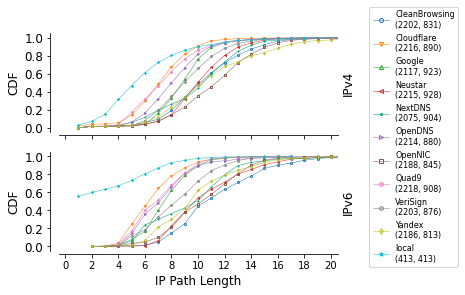

In [11]:
fig, (ax_v4, ax_v6) = plt.subplots(figsize=(5,4), nrows=2)

for (ttl_cdf, ax) in [(ttl_v4, ax_v4), (ttl_v6, ax_v6)]:
    
    for k in sorted(ttl_cdf.keys()):
        
        ax.plot(ttl_cdf[k].xs, ttl_cdf[k].ps,
                label=k.split(' ')[0] + '\n(' + str(v4_samples[k]) + ', ' + str(v6_samples[k]) + ')' , color=colors[k],
                marker=markers[k], markersize=2, # markevery=max(1, len(ttl_cdf[k].xs)/50),
                linewidth=0.5, fillstyle='none')
        
        ax.set_yticks(np.arange(0, 1.1, 0.2))
#         ax.set_xscale('symlog')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('axes', -0.03))
        ax.spines['left'].set_position(('axes', -0.03))
        ax.set_xlim([-0.5, 20.5])
        ax.set_xticks(np.arange(0,21,2))


ax_v4.set_xlabel('')
ax_v6.set_xlabel('IP Path Length')

ax_v4.set_title('')
ax1_ = ax_v4.twinx()
ax1_.spines['right'].set_color('none')
ax1_.spines['top'].set_color('none')
ax1_.spines['left'].set_color('none')
ax1_.spines['bottom'].set_color('none')
ax1_.yaxis.set_ticks_position('none')
ax1_.set_ylabel('IPv4')
plt.setp(ax1_.get_yticklabels(), visible = False)

ax_v6.set_title('')
ax2_ = ax_v6.twinx()
ax2_.spines['right'].set_color('none')
ax2_.spines['top'].set_color('none')
ax2_.spines['left'].set_color('none')
ax2_.spines['bottom'].set_color('none')
ax2_.yaxis.set_ticks_position('none')
ax2_.set_ylabel('IPv6')
plt.setp(ax2_.get_yticklabels(), visible = False)

ax_v4.set_ylabel('CDF')
ax_v6.set_ylabel('CDF')

plt.setp(ax_v4.get_xticklabels(), visible = False)

# ax_v4.legend(loc = 'lower left', markerscale = 2, fontsize = 10, ncol=2, bbox_to_anchor=(-0.2,1.05))
ax_v4.legend(loc = 'lower left', markerscale = 2, fontsize = 8, ncol=1, bbox_to_anchor=(1.1,-1.4))
    
fig.savefig('../plots/traceroute-ttl-v4v6.pdf', bbox_inches='tight')
fig.savefig('../plots/traceroute-ttl-v4v6.eps', bbox_inches='tight')

In [12]:
for k in sorted(ttl_v4.keys()):
    print(k)
    for l in list(zip(ttl_v4[k].xs, ttl_v4[k].ps)):
        print(l)
    print('=================')

CleanBrowsing
(1, 0.0013623978201634877)
(2, 0.015440508628519528)
(3, 0.017711171662125342)
(4, 0.021798365122615803)
(5, 0.031335149863760216)
(6, 0.05722070844686648)
(7, 0.09536784741144415)
(8, 0.19391462306993643)
(9, 0.34150772025431425)
(10, 0.4854677565849228)
(11, 0.611716621253406)
(12, 0.723433242506812)
(13, 0.8083560399636693)
(14, 0.8755676657584015)
(15, 0.9250681198910081)
(16, 0.9654859218891917)
(17, 0.9818346957311535)
(18, 0.989100817438692)
(19, 0.9931880108991825)
(20, 0.9977293369663942)
(21, 0.9990917347865577)
(22, 0.9995458673932789)
(26, 1.0)
Cloudflare
(1, 0.023014440433212997)
(2, 0.0388086642599278)
(3, 0.042418772563176894)
(4, 0.057310469314079425)
(5, 0.14259927797833935)
(6, 0.2937725631768953)
(7, 0.48826714801444043)
(8, 0.677797833935018)
(9, 0.8231046931407943)
(10, 0.9133574007220217)
(11, 0.967057761732852)
(12, 0.9828519855595668)
(13, 0.9914259927797834)
(14, 0.9954873646209387)
(15, 0.9972924187725631)
(16, 0.9990974729241877)
(17, 0.99954873

In [13]:
for k in sorted(ttl_v6.keys()):
    print(k)
    for l in list(zip(ttl_v6[k].xs, ttl_v6[k].ps)):
        print(l)
    print('=================')

CleanBrowsing
(2, 0.0012033694344163659)
(3, 0.0024067388688327317)
(5, 0.009626955475330927)
(6, 0.013237063778580024)
(7, 0.048134777376654635)
(8, 0.15042117930204574)
(9, 0.2539109506618532)
(10, 0.44765342960288806)
(11, 0.5391095066185319)
(12, 0.6353790613718412)
(13, 0.7111913357400722)
(14, 0.7833935018050542)
(15, 0.8688327316486161)
(16, 0.901323706377858)
(17, 0.927797833935018)
(18, 0.9578820697954272)
(19, 0.9771359807460891)
(20, 0.9891696750902527)
(21, 0.9951865222623345)
(22, 1.0)
Cloudflare
(2, 0.0011235955056179776)
(3, 0.0033707865168539327)
(4, 0.0348314606741573)
(5, 0.24831460674157305)
(6, 0.44831460674157303)
(7, 0.6460674157303371)
(8, 0.7865168539325843)
(9, 0.8730337078651685)
(10, 0.9415730337078652)
(11, 0.9696629213483146)
(12, 0.9853932584269663)
(13, 0.9910112359550561)
(14, 0.996629213483146)
(15, 0.9977528089887641)
(16, 1.0)
Google
(2, 0.0021668472372697724)
(3, 0.0032502708559046588)
(4, 0.005417118093174431)
(5, 0.0780065005417118)
(6, 0.169014084